In [42]:
import numpy as np
import matplotlib.pyplot as plt
from prompt_toolkit.formatted_text import fragment_list_width
from scipy.optimize import curve_fit
import pandas as pd

In [69]:
file = "Einstein_A_Good.xlsx"

cols = [["I_80", "F_80"], ["I_90","F_90"],["I_100", "F_100"]]
bins = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])


# Model

def Amplitude_model(x,A0,T):
    omega = 2* np.pi*x
    return((A0*T)/np.sqrt(1+(omega**2)*(T**2)))


p0_guess = [0.01, 0.003]

bounds_guess = (
    [0, 0],  # Lower bounds
    [np.inf, np.inf]  # Upper bounds
)

df = pd.read_excel(file)


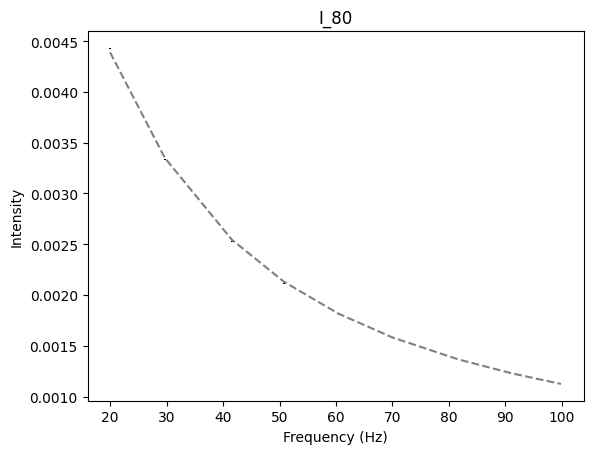

80K time const: 0.009638997982729562 time err: 3.804251704936626e-05
80K A0: 0.7148254612439708 A0_err: 0.00033338514593798956


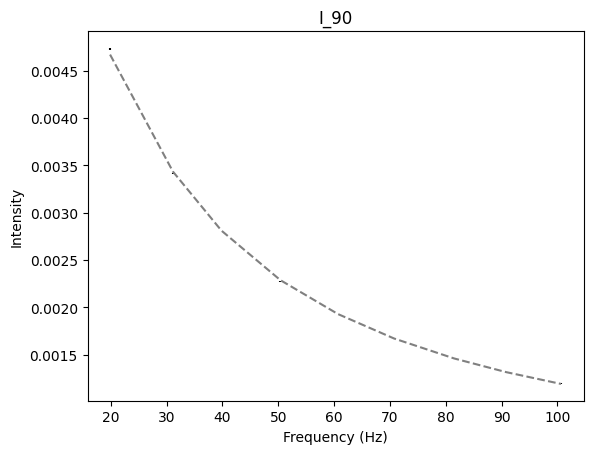

90K time const: 0.009503127456928844 time err: 3.917651628517855e-05
90K A0: 0.7628949449303538 A0_err: 0.00031276731295456936


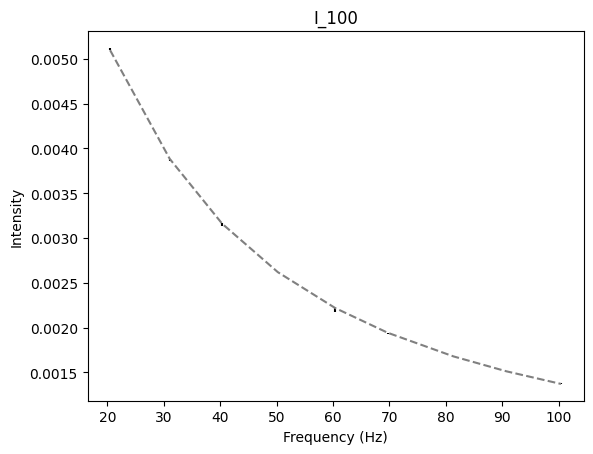

100K time const: 0.008695917985756123 time err: 4.042194557856223e-05
100K A0: 0.8792712119475221 A0_err: 0.0006422573476893454


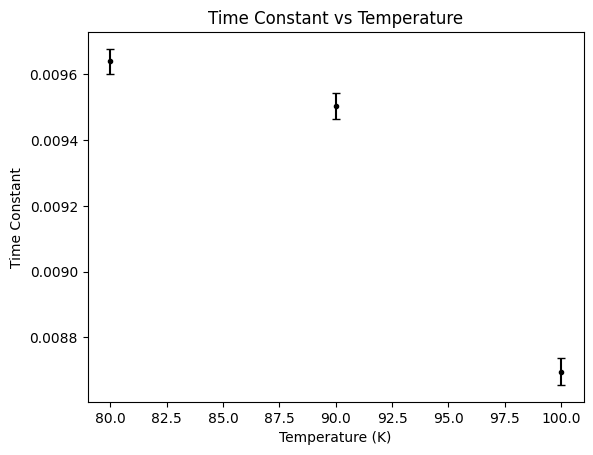

In [70]:
# Dictionary to store results by temperature
results = {}

for I_col, F_col in cols:

    # Extract temperature from column name
    temp = I_col.split("_")[1] + "K"

    xdata = df[F_col].to_numpy()
    ydata = df[I_col].to_numpy()

    freq_values = []
    freq_uncertainty = []

    int_values = []
    int_uncertainty = []

    # Bin averaging
    for b in bins:

        mask = (xdata > b - 2) & (xdata < b + 2)

        frequency = xdata[mask]
        intensity = ydata[mask]

        if len(frequency) == 0:
            continue

        mean_freq = np.mean(frequency)
        err_freq = np.std(frequency) / np.sqrt(len(frequency))

        mean_intensity = np.mean(intensity)
        err_intensity = np.std(intensity) / np.sqrt(len(intensity))

        freq_values.append(mean_freq)
        freq_uncertainty.append(err_freq)

        int_values.append(mean_intensity)
        int_uncertainty.append(err_intensity)

    freq_values = np.array(freq_values)
    freq_uncertainty = np.array(freq_uncertainty)
    int_values = np.array(int_values)
    int_uncertainty = np.array(int_uncertainty)

    # Fit amplitude model
    pop, cov = curve_fit(
        Amplitude_model,
        freq_values,
        int_values,
        sigma=int_uncertainty,
        absolute_sigma=True,
        p0=p0_guess,
        bounds=bounds_guess
    )

    A0_fit, T_fit = pop
    A0_err, T_err = np.sqrt(np.diag(cov))

    # Einstein A coefficient and propagated error
    A_coeff = 1 / T_fit
    A_err = T_err / (T_fit ** 2)

    # Store results
    results[temp] = {
        "freq": freq_values,
        "freq_err": freq_uncertainty,
        "int": int_values,
        "int_err": int_uncertainty,
        "A0": A0_fit,
        "A0_err": A0_err,
        "time_const": T_fit,
        "time_err": T_err,
        "A_coeff": A_coeff,
        "A_err": A_err
    }

    plt.figure(1)
    plt.errorbar(freq_values, int_values, yerr=int_uncertainty, color = "black", fmt = "none")
    plt.plot(freq_values, Amplitude_model(freq_values, *pop), color = "grey", linestyle = "--")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Intensity")
    plt.title(I_col)
    plt.show()

    print(f"{temp} time const: {T_fit} time err: {T_err}")
    print(f"{temp} A0: {A0_fit} A0_err: {A0_err}")

# Extract Temperature vs A coefficient

temperatures = []
T_values = []
T_errors = []

for temp in results:
    T_val = float(temp.replace("K", ""))

    temperatures.append(T_val)
    T_values.append(results[temp]["time_const"])
    T_errors.append(results[temp]["time_err"])

temperatures = np.array(temperatures)
T_values = np.array(T_values)
T_errors = np.array(T_errors)

# Sort by temperature
order = np.argsort(temperatures)
temperatures = temperatures[order]
T_values = T_values[order]
T_errors = T_errors[order]

# Plot Temperature vs Einstein A coefficient

plt.figure()

plt.errorbar(
    temperatures,
    T_values,
    yerr=T_errors,
    fmt='o',
    markersize =3,
    capsize =3,
    color ="black",
)

plt.xlabel("Temperature (K)")
plt.ylabel("Time Constant")
plt.title("Time Constant vs Temperature")

plt.show()